In [2]:
import warnings
from datetime import datetime

import datadotworld as dw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.offline as pyo
import plotly.graph_objs as go
import seaborn as sns

In [3]:
%matplotlib inline
pyo.init_notebook_mode(connected=True)
sns.set_style('ticks')
warnings.filterwarnings(action='ignore')

## calculating PM Compliance measure

In [4]:
dataworld_dataset = dw.load_dataset('dgs-kpis/fmd-maintenance')
data = dataworld_dataset.dataframes['archibus_maintenance_data']

In [5]:
dframe = data.copy()[['wo_id','date_completed','prob_type','date_requested']]
dframe['date_completed'] = pd.to_datetime(dframe['date_completed'])
dframe['date_requested'] = pd.to_datetime(dframe['date_requested'])
dframe.set_index('date_requested', inplace=True)
dframe['duration'] = (dframe['date_completed'] - dframe.index).dt.days
dframe['fiscal_year'] = np.where(dframe.index.month >= 7, 
                                 dframe.index.year + 1,
                                 dframe.index.year)
dframe.sort_index(inplace=True)

## calculate compliance standard for PM Compliance measure

In [6]:
pm_types = ['HVAC|PM','BUILDING PM','PREVENTIVE MAINT',
            'FUEL INSPECTION','BUILDING INTERIOR INSPECTION',
            'INSPECTION']
# below fiscal year window hardcoded but could easily be dynamic
last_3_fiscalyears = [2016,2017,2018]
# filter dataframe for fiscal years 16 through 18 & PMs only 
dframe = dframe[(dframe['prob_type'].isin(pm_types)) &
               (dframe['fiscal_year'].isin(last_3_fiscalyears))]

In [7]:
# get list for each problem type with mean duration for each year
# find median value for each problem type to use as standard
pm_durations = {}
for pm in dframe['prob_type'].unique():
    temp_list = []
    pm_durations[pm] = temp_list
    
    for yr in dframe['fiscal_year'].unique():
        temp_list.append(
            dframe[(dframe['prob_type']==pm) &
                  (dframe['fiscal_year']==yr)]
            ['duration'].mean() )

In [8]:
pm_durations

{'BUILDING INTERIOR INSPECTION': [0.0, 7.071428571428571, 4.921052631578948],
 'BUILDING PM': [0.6140350877192983, 0.0, 0.2073170731707317],
 'HVAC|PM': [15.16, 29.0, 18.5],
 'INSPECTION': [23.333333333333332, 13.222222222222221, 7.402298850574713],
 'PREVENTIVE MAINT': [18.792067307692307,
  29.66640190627482,
  18.632425742574256]}

In [10]:
standard = {}
for key,value in pm_durations.items():
    standard[key] = int(np.round(np.median(value)))
standard

{'BUILDING INTERIOR INSPECTION': 5,
 'BUILDING PM': 0,
 'HVAC|PM': 18,
 'INSPECTION': 13,
 'PREVENTIVE MAINT': 19}

## create standard column

In [14]:
dframe['standard'] = (dframe['prob_type']
                      .map(lambda x: standard[x]))

## get fy18 actuals for PM Compliance

In [15]:
dframe_fy18 = dframe[(dframe['fiscal_year']==2018)]
dframe_fy18['compliant'] = (np.where(
    dframe_fy18['duration'] <= dframe_fy18['standard'],1,0))

In [16]:
compliant_pms_count =  dframe_fy18['compliant'].sum()
all_pms_count =  dframe_fy18['prob_type'].count()
pm_compliance = (compliant_pms_count / all_pms_count) * 100

print('PM Compliance for fy18 was: {:.2f}%'.format(pm_compliance))

PM Compliance for fy18 was: 65.69%


##  changes in compliance rate over last 3 fiscal years

In [17]:
dframe['compliant_pm'] = (np.where(
    dframe['duration'] <= dframe['standard'],1,0))

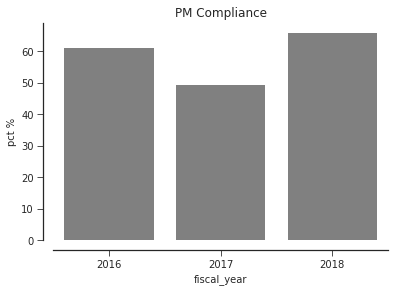

In [18]:
last_3years_compliance =(
    dframe.groupby('fiscal_year')['compliant_pm'].sum() /
    dframe.groupby('fiscal_year')['prob_type'].count()) * 100

sns.barplot(x=last_3years_compliance.index,
            y=last_3years_compliance.values,
           color='grey')
sns.despine(offset=10)
plt.ylabel('pct %')
plt.title('PM Compliance');

In [19]:
last_3years_compliance

fiscal_year
2016    60.987415
2017    49.381107
2018    65.694683
dtype: float64

##  volume over last 3 fiscal years 

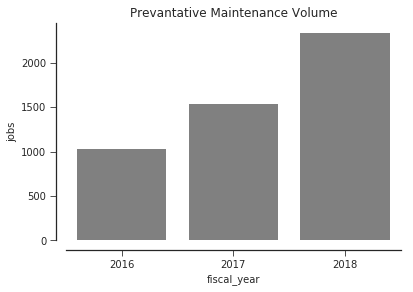

In [20]:
last_3years_volume =(
    dframe.groupby('fiscal_year')['prob_type'].count()) 

sns.barplot(x=last_3years_volume.index,
            y=last_3years_volume.values,
           color='grey')
sns.despine(offset=10)
plt.ylabel('jobs')
plt.title('Prevantative Maintenance Volume');

##  distribution of durations over last 3 years

In [53]:
traces = []
format_names = ([pm if len(pm.split()) == 1 else
  '{}'.format(pm.split()[0] + '<br>' + pm.split()[1])
  for pm in dframe['prob_type'].unique()])

for pm, name in zip(dframe['prob_type'].unique(),format_names):
    
    traces.append(go.Box(
        y = (dframe[(dframe['prob_type']==pm)]
             ['duration'].tolist()),
        boxpoints = 'all',
        jitter = .3,
        pointpos = -1.8,
        marker = {'size':5},
        line = {'width':1,},
        name = name
        
    ))
layout = go.Layout(
    title = 'PM durations last 3 fiscal years',
    hovermode = 'closest',
    paper_bgcolor = 'rgb(243,243,243)',
    plot_bgcolor = 'rgb(243,243,243)')
fig = {'data':traces, 'layout':layout}
pyo.iplot(fig)